# Archetype Analysis

In [1]:
import archetypes as arch
from sklearn.datasets import load_iris

In [2]:
wine = load_iris()

X = wine.data
target = wine.target

In [3]:
model = arch.AA(n_archetypes=3, n_init=10, max_iter=10_000, tol=1e-16, random_state=0)
model.fit(X)

model.archetypes_

array([[4.9618196 , 2.19090202, 3.88180404, 1.26726283],
       [7.65958922, 3.36383863, 6.62786975, 2.26350244],
       [4.91092405, 3.53448202, 1.10256847, 0.16616813]])

/Users/aleix11alcacer/Projects/archetypes/archetypes/visualization/simplex.py:75: RuntimeWarning: invalid value encountered in true_divide
  projections /= np.linalg.norm(projections, axis=1)[:, None]


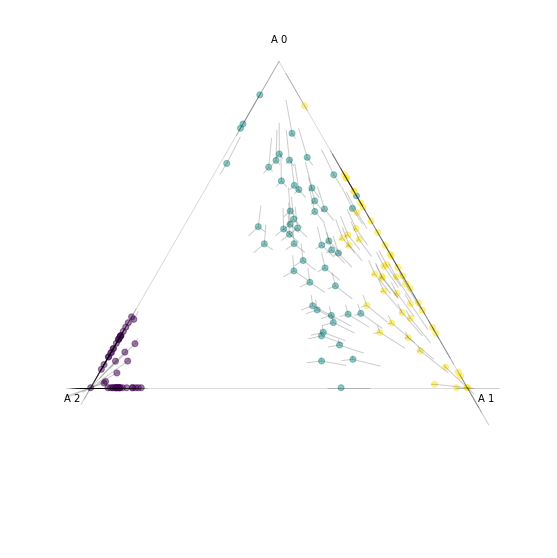

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
arch.simplex(model.alphas_, c=target, alpha=0.5, show_circle=False, show_direction=True)

plt.show()